In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

In [2]:
import numpy as np
import scipy.optimize as sciopt

#===========================================================================================================================================================================
#Module Functions
#===========================================================================================================================================================================

def constrNM(func,x0,LB,UB,args=(),xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=0, retall=0, callback=None):
    """Constrained Nelder-Mead optimizer.
    Transforms a constrained problem

    Args:
        func (function): Objective function.
        x0 (numpy.ndarray): Initial guess.
        LB (numpy.ndarray): Lower bounds.
        UB (numpy.ndarray): Upper bounds.

    Keyword Args:
        args (tuple): Extra arguments passed to func, i.e. ``func(x,*args).``
		  xtol (float) :Absolute error in xopt between iterations that is acceptable for convergence.
		  ftol(float) : Absolute error in ``func(xopt)`` between iterations that is acceptable for convergence.
		  maxiter(int) : Maximum number of iterations to perform.
		  maxfun(int) : Maximum number of function evaluations to make.
		  full_output(bool) : Set to True if fopt and warnflag outputs are desired.
		  disp(bool) : Set to True to print convergence messages.
		  retall(bool): Set to True to return list of solutions at each iteration.
		  callback(callable) : Called after each iteration, as ``callback(xk)``, where xk is the current parameter vector.
    """
    # Check input
    if len(LB)!=len(UB) or len(LB)!=len(x0):
        raise ValueError('Input arrays have unequal size.')
    # Check if x0 is within bounds
    for i,x in enumerate(x0):
        if LB[i] is not None:
            if not (x > LB[i]):
                x = LB[i]
        else:
            print('LB is None')
        if UB[i] is not None:
            if not (x < UB[i]):
                x = UB[i]
        else:
            print('UB is None')

    # Transform x0
    x0=transformX0(x0,LB,UB)

    # Stick everything into args tuple
    opts=tuple([func, LB, UB,args])

    # Call fmin
    res=sciopt.fmin(constrObjFunc,x0,args=opts,ftol=ftol,xtol=xtol,maxiter=maxiter,disp=disp,
        full_output=full_output,callback=callback,maxfun=maxfun,retall=retall)

    # Convert res to list
    res=list(res)

    # Dictionary for results
    rDict={'fopt': None, 'iter': None, 'funcalls': None, 'warnflag': None, 'xopt': None, 'allvecs': None}

    # Transform back results
    if full_output or retall:
        r=transformX(res[0],LB,UB)
    else:
        r=transformX(res,LB,UB)
    rDict['xopt']=r

    # If full_output is selected, enter all results in dict
    if full_output:
        rDict['fopt']=res[1]
        rDict['iter']=res[2]
        rDict['funcalls']=res[3]
        rDict['warnflag']= res[4]

    # If retall is selected, transform back all values and append to dict
    if retall:
        allvecs=[]
        for r in res[-1]:
            allvecs.append(transformX(r,LB,UB))
        rDict['allvecs']=allvecs

    return rDict

def constrObjFunc(x,func,LB,UB,args):
    """Objective function when using Constrained Nelder-Mead.
    Calls :py:func:`TransformX` to transform ``x`` into
    constrained version, then calls objective function ``func``.

    Args:
        x (numpy.ndarray): Input vector.
        func (function): Objective function.
        LB (numpy.ndarray): Lower bounds.
        UB (numpy.ndarray): Upper bounds.

    Keyword Args:
        args (tuple): Extra arguments passed to func, i.e. ``func(x,*args).``

    Returns:
        float: Return value of ``func(x,*args)``.
    """

    #print x\
    x=transformX(x,LB,UB)
    #print x
    #raw_input()

    return func(x,*args)

def transformX(x,LB,UB,offset=1E-20):
    """Transforms ``x`` into constrained form, obeying upper bounds ``UB`` and lower bounds ``LB``.
    .. note:: Will add tiny offset to LB if ``LB[i]=0``, to avoid singularities.

    Idea taken from http://www.mathworks.com/matlabcentral/fileexchange/8277-fminsearchbnd--fminsearchcon

    Args:
        x (numpy.ndarray): Input vector.
        LB (numpy.ndarray): Lower bounds.
        UB (numpy.ndarray): Upper bounds.

    Keyword Args:
        offset (float): Small offset added to lower bound if LB=0.

    Returns:
        numpy.ndarray: Transformed x-values.

    """

    #Make sure everything is float
    x=np.asarray(x,dtype=np.float64)
    #LB=np.asarray(LB,dtype=np.float64)
    #UB=np.asarray(UB,dtype=np.float64)

    # Add offset if necessary to avoid singularities
    for l in LB:
        if l==0:
            l=l+offset

    #Determine number of parameters to be fitted
    nparams=len(x)

    #Make empty vector
    xtrans = np.zeros(np.shape(x))

    # k allows some variables to be fixed, thus dropped from the
    # optimization.
    k=0

    for i in range(nparams):
        #Upper bound only
        if UB[i] is not None and LB[i] is None:
            xtrans[i]=UB[i]-x[k]**2
            k=k+1

        #Lower bound only
        elif UB[i] is None and LB[i] is not None:
            xtrans[i]=LB[i]+x[k]**2
            k=k+1

        #Both bounds
        elif UB[i] is not None and LB[i] is not None:
            xtrans[i] = (np.sin(x[k])+1.)/2.*(UB[i] - LB[i]) + LB[i]
            xtrans[i] = max([LB[i],min([UB[i],xtrans[i]])])
            k=k+1

        #No bounds
        elif UB[i] is None and LB[i] is None:
            xtrans[i] = x[k]
            k=k+1

            #NOTE: The original file has here another case for fixed variable. We might need to add this here!!!

    return np.array(xtrans)

def transformX0(x0,LB,UB):
    r"""Transforms ``x0`` into constrained form, obeying upper bounds ``UB`` and lower bounds ``LB``.
    Idea taken from http://www.mathworks.com/matlabcentral/fileexchange/8277-fminsearchbnd--fminsearchcon

    Args:
        x0 (numpy.ndarray): Input vector.
        LB (numpy.ndarray): Lower bounds.
        UB (numpy.ndarray): Upper bounds.

    Returns:
        numpy.ndarray: Transformed x-values.
    """

    #Turn into list
    x0u = list(x0)

    k=0
    for i in range(len(x0)):
        #Upper bound only
        if UB[i] is not None and LB[i] is None:
            if UB[i]<=x0[i]:
                x0u[k]=0
            else:
                x0u[k]=np.sqrt(UB[i]-x0[i])
            k=k+1

        #Lower bound only
        elif UB[i] is None and LB[i] is not None:
            if LB[i]>=x0[i]:
                x0u[k]=0
            else:
                x0u[k]=np.sqrt(x0[i]-LB[i])
            k=k+1

        #Both bounds
        elif UB[i] is not None and LB[i] is not None:
            if UB[i]<=x0[i]:
                x0u[k]=np.pi/2
            elif LB[i]>=x0[i]:
                x0u[k]=-np.pi/2
            else:
                x0u[k] = 2*(x0[i] - LB[i])/(UB[i]-LB[i]) - 1;
                #shift by 2*pi to avoid problems at zero in fmin otherwise, the initial simplex is vanishingly small
                x0u[k] = 2*np.pi+np.arcsin(max([-1,min(1,x0u[k])]));
            k = k+1

        #No bounds
        elif UB[i] is None and LB[i] is None:
            x0u[k] = x0[i]
            k=k+1

    return np.array(x0u)

def printAttr(name,attr,maxL=5):
    """Prints single attribute in the form attributeName = attributeValue.
    If attributes are of type ``list`` or ``numpy.ndarray``, will check if the size
    exceeds threshold. If so, will only print type and dimension of attribute.

    Args:
        name (str): Name of attribute.
        attr (any): Attribute value.

    Keyword Args:
        maxL (int): Maximum length threshold.

    """

    if isinstance(attr,(list)):
        if len(attr)>maxL:
            print(name, " = ", getListDetailsString(attr))
            return True
    elif isinstance(attr,(np.ndarray)):
        if min(attr.shape)>maxL:
            print(name, " = ", getArrayDetailsString(attr))
            return True

    print(name, " = ", attr)

    return True

def getListDetailsString(l):
    """Returns string saying "List of length x", where x is the length of the list.

    Args:
        l (list): Some list.

    Returns:
        str: Printout of type and length.

    """

    return "List of length " + str(len(l))

def getArrayDetailsString(l):
    """Returns string saying "Array of shape x", where x is the shape of the array.
    Args:
        l (numpy.ndarray): Some array.

    Returns:
        str: Printout of type and shape.
    """
    return "Array of shape " + str(l.shape)

def printDict(dic,maxL=5):
    """Prints all dictionary entries in the form key = value.
    If attributes are of type ``list`` or ``numpy.ndarray``, will check if the size
    exceeds threshold. If so, will only print type and dimension of attribute.

    Args:
        dic (dict): Dictionary to be printed.

    Returns:
        bool: True

    """

    for k in dic.keys():
        printAttr(k,dic[k],maxL=maxL)

    return True

### Reading input data

In [3]:
def readData(filename, NumDataSet):
    ### Read CSV into raw_data dataframe ###
    input_data = pd.read_csv(filename)
    raw_data_header = input_data.columns[1:NumDataSet+1].tolist()
    ### Print Data headers
    print('Input Data File Header:', raw_data_header)

    ### number of columns and rows in raw_data (shape only for dataframe)
    input_data_numrows = input_data.shape[0]
    #input_data_numcols = input_data.shape[1]- NumDataSet #minus off the std deviation data
    input_data_numcols = 1 + NumDataSet
    print('Input Data: Rows -', input_data_numrows, ', Columns -', input_data_numcols)

    ### Saving raw_data columns into individual list (rows) in rfp_data numpy
    # Flip row and col from raw_data --> can simply use pandas transpose
    rfp_data = np.zeros((input_data_numcols, input_data_numrows))
    for i in range(0, input_data_numcols): # Iterate through all columns
        rfp_data[i, :] = input_data.iloc[:, i]
    
    rfp_data_numrows = rfp_data.shape[0]
    rfp_data_numcols = rfp_data.shape[1]
    
    '''
    ### Convert RFP/OD into (mol/OD) ###
    # Starts from 1 because Row 0 is time
    for i in range (1, rfp_data_numrows):
        for j in range (0, rfp_data_numcols):
            rfp_data[i][j] = ODconv(rfp_data[i][j])
    '''
    ## What is the following for?
                
    #store standard deviation data
    stddev_data = np.zeros((NumDataSet, input_data_numrows))

    for i in range(input_data_numcols, input_data_numcols + NumDataSet): # Iterate through all columns
        stddev_data[i-input_data_numcols, :] = 0.0 #input_data.iloc[:, i]

    stddev_data_numrows = stddev_data.shape[0]
    stddev_data_numcols = stddev_data.shape[1]
    
    
    # convert RFP/OD into Molar/OD
    for i in range(0, stddev_data_numrows):
        for j in range(0, stddev_data_numcols):
            stddev_data[i][j] = ODconv(stddev_data[i][j])
    
    return raw_data_header, rfp_data, stddev_data

def ODconv(x):
    x_conv = x *(1 / 18.814) * (1 / 30) * (10 ** -6)
    return x_conv

def indconv_Percent(raw_data_header, Molar_Mass):
    ### Convert Inducer from % into (mol/L) ###
    numInd = np.size(raw_data_header)
    inducer_array = np.zeros(numInd)

    Inducer_MM = Molar_Mass
    #Arabinose_MM = 150.13  # g/mol
    # Starts from 1 because Row 0 is time
    
    inducer_array = raw_data_header[0:numInd]
    print(inducer_array)
    for i in range (0,numInd):
        #read only the digit (exclude the unit)
        ##inducer_array[i] = ''.join([c for c in inducer_array[i] if c in '1234567890.'])
        inducer_array[i] = 208
        inducer_array[i] = float(inducer_array[i])
        inducer_array[i] = ((inducer_array[i]) / Inducer_MM)
    return inducer_array

def plot_inputdata(input_data_header, rfp_data, stddev_data):
    ### Defining time array from Row 0 of rfp_data
    time = rfp_data[0]

    # Time grid == no. of times to report solution
    rfp_data_numrows = np.size(rfp_data, 0)
    # rfp_data_numcols = np.size(rfp_data, 1)

    #fig = plt.figure(figsize=(5,3.6))
    #ax = fig.add_axes([0.16,0.15,0.8,0.78])
    ### Plot RFP Data vs Time ###
    # plt.figure()
    #style = ['^','*','>','D','<','s','p','o','d','+','h','x','v','.','H']
    for i in range (1, rfp_data_numrows):
        plt.plot(time, rfp_data[i], linestyle='None', marker='+', markersize=4) 

    ### Figure Settings
    #plt.rc('font', size=12)  # controls default text sizes
    rfp_data_legend = input_data_header[0:rfp_data_numrows]
    plt.legend(rfp_data_legend)
    #plt.title('Experimental Peptide Concentration vs Time')
    plt.xlabel('Time (min)')
    plt.ylabel('RFP/OD')

    # Set Y Axis Ticker to Scientific Style
    
    #plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    #plt.rcParams["figure.figsize"] = 5,3.5  # Set figure width to 12 and height to 9
    #plt.figure(dpi = 600)
    # Figure border
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #axes = plt.gca()
    #ymin, ymax = axes.get_ylim()
    #axes.set_ylim([0, ymax+0.25*ymax])
    plt.show()

def run_readdata(input_data_filename, NumDataSet, inducer_const):
    print('\tFilename:', input_data_filename)
    print('\tInducer Unit:', inducer_const)

    ### Execute readData Function ###
    # data_header: Deader row from the raw data file
    # data_array: Extracted RFP data in a new array
    data_header, data_array, Data_stddev = readData(input_data_filename, NumDataSet)

    ### Find Sample Size ###
    Data_array_numrows = data_array.shape[0]    # Time + All Inducers
    Data_array_numcols = data_array.shape[1]    # Number of RFP Data Per Inducer
    sample_size = (Data_array_numrows - 1) * Data_array_numcols

    ### Convert Inducer Unit ###
    ### Independent variable # Inducer concentration tuple
    if inducer_const == '%':
        #inducer_molar_mass = input("Please insert the Inducer Molar Mass (in g/mol): ")
        #inducer_molar_mass = float(inducer_molar_mass)
        inducer_molar_mass = 1.0
        inducer = indconv_Percent(data_header, inducer_molar_mass)
    '''
    elif inducer_const == 'dimensionless':
        inducer = indconv_None(data_header)
    else:   # for cases with 10**-6 or 10**-9
        inducer = indconv(data_header, inducer_const)
    '''
    print('Inducers Used:', inducer)  # ind for checking (Values after conversion to M)

    ### Convert inducer to log10
    inducer_log = np.log10(inducer)
    print('Inducers (log10):', inducer_log)
    print(type(inducer_log))
    print(np.shape(inducer_log))
    
    plot_inputdata(data_header, data_array, Data_stddev)

    return(data_header, data_array, Data_stddev, inducer, inducer_log, sample_size)

### Dose Response

In [4]:
def run_AIC(SSE_array, sample_size, num_param):
    SSE_len = len(SSE_array)
    AIC_array = []  #It is initialized as a list, not a numpy array

    for i in range (0,SSE_len):
        AIC_value = sample_size * np.log(SSE_array[i]/sample_size) + 2*num_param[i]
        AIC_array.append(AIC_value)

    return(AIC_array)

def compute_hilleqn(inducer, param):
    
    n_Km = param[0]
    K_ind_Km = param[1]
    Vm_Km = param[2]
    Kbasal = 0
    
    numInd = len(inducer)
    model_peakrfp = np.zeros(numInd)

    for i in range(0, numInd-1):  #why minus 1 inducer?
        ind = inducer[i]
        model_peakrfp[i] = Kbasal + Vm_Km*((ind**n_Km) / (ind**n_Km + K_ind_Km**n_Km))

    #print(model_peakrfp)
    return model_peakrfp

def findSSE_Km(param, inducer, rfp_data, Inhibition):
    
    model_peakrfp = compute_hilleqn(inducer, param)
    numInd = len(inducer)
    rfp_max = np.zeros(numInd)
    for i in range(0, numInd):
        # +1 because index 0 is time
        rfp_max[i] = max(rfp_data[i + 1])

    ###Calculate SSE
    sse_Km = 0
    for i in range (0,numInd-1):
        sse_Km = sse_Km + (rfp_max[i] - model_peakrfp[i]) ** 2
    return sse_Km

def plotData_Km(raw_data_header, rfp_data, data_stddev, inducer, inducer_log, param_optimized, Inhibition):
    
    numInd = len(inducer)
    rfp_max = np.zeros(numInd)
    for i in range(0, numInd):
        rfp_max[i] = max(rfp_data[i + 1])

    rfp = np.zeros(numInd)
    rfp = compute_hilleqn(inducer, param_optimized)
    
    plt.errorbar(inducer_log, rfp_max, yerr=data_stddev[:,-1], linestyle='None', marker='s', label='Experiment')
    plt.plot(inducer_log, rfp, label = 'Model')
    plt.legend(loc='upper left')
    plt.xlabel('Inducer Concentration ($log_{10}$ (M))')
    plt.ylabel('Expression Level (M/OD)')
    plt.show()

def run_DoseRes(data_header, data_array, data_stddev, inducer, inducer_log, Inhibition):

    ### Find rfp Max for each inducer
    numInd = len(inducer)
    rfp_max = np.zeros(numInd)
    
    print(np.size(data_array))
    
    for i in range(0, numInd):
        rfp_max[i] = max(data_array[i + 1])

    ### Run Optimizer ###
    numParam_Km = 3;

    Vm_max = max(rfp_max)
    ind_mean = (inducer_log[0]+inducer_log[len(inducer_log)-1])/2
    K_ind0 = 10**ind_mean # Convert back from log10

    param0_global_Km = [(0.1, 4), (K_ind0*0.8, K_ind0*1.2), (Vm_max*0.9, Vm_max*1.1)] # (0, Vm_min)]
    #param0_global_Km = [(0.1, 4), (K_ind0*0.8, K_ind0*1.2), (Vm_max*0.9, Vm_max*1.1)]#, (0, Vm_min)]

    result_diffevo_Km = differential_evolution(findSSE_Km, param0_global_Km, args=(inducer, data_array, Inhibition), tol=1e-12)
    
    param0_local_Km = np.zeros(numParam_Km)
    for i in range(0, numParam_Km):
        param0_local_Km[i] = result_diffevo_Km.x[i]
    
    result_NM_Km = minimize(findSSE_Km, param0_local_Km, args=(inducer, data_array, Inhibition), method='nelder-mead', options={'xtol': 1e-15, 'disp': False})
    
    param_optimized_Km = np.zeros(numParam_Km)
    for i in range(0, numParam_Km):
        param_optimized_Km[i] = result_NM_Km.x[i]
        #param_optimized_Km[i] = result_diffevo_Km.x[i]

    ### Calculate and plot Model results (param_optimized) ###
    # param_optimized_Km = [3.05784966e+00,  4.57058298e-09,   6.28748162e-06]
    plotData_Km(data_header, data_array, data_stddev, inducer, inducer_log, param_optimized_Km, Inhibition)
    
    n, K_ind = param_optimized_Km[0:2]
    return(n, K_ind)

In [20]:
#original one
class InduciblePromoterLibrary:
    
    ### Single-ODE Model for Constant Inducible Promoter ###
    def solveODE_ConstantInducer(y, t, inducer, param, Operation='Solve'):
        # Dependent variables
        GFP = y[0]
        # Parameters
        n = param[0]
        K_ind = param[1]
        syn_GFP = param[2]
        deg_GFP = param[3]
        
        dGFP_dt = (syn_GFP * ((inducer**n)/(inducer**n+K_ind**n))) - (deg_GFP * GFP)
        #dPep_dt = syn_Pep-(deg_Pep*Pep)

        return dGFP_dt
        
    function_mappings = {
        'solveODE_ConstantInducer': solveODE_ConstantInducer
    }

    def select_function(self, SystemTypeString):
        return self.function_mappings[SystemTypeString]
    
    def ComputeSSE(self, param, y0, inducer, rfp_data, time_int, SystemType, VarIndex, OptimizerType):
        ### Calculate SSE - To be minimized by Optimizer ####

        global weight_global, sse_global
        col = 3

        # Time grid == no. of times to report solution
        rfp_data_numrows = np.size(rfp_data, 0)
        rfp_data_numcols = np.size(rfp_data, 1)
        numInd = np.size(inducer)
        
        t_start = rfp_data[0][0] # First value of Time column
        t_end = rfp_data[0][-1] # Last value of Time column
        dt = 1  # minutes
        timestep = int((t_end / dt) + 1)
        t = np.linspace(t_start, t_end, timestep)

        # Initialize mRNA and Pep nested list
        #mRNA = np.zeros((timestep, numInd), dtype=object)  # timestep (rows) x numInd (cols)
        Pep = np.zeros((timestep, numInd), dtype=object)   # timestep (rows) x numInd (cols)
        # Pep2 is transpose of Pep, used to find Pep max
        Pep2 = np.zeros((numInd, timestep), dtype=object)  # numInd(rows) x timestep (cols)

        solveODE_Name = '_'.join(('solveODE', SystemType))
        solveODEfun = self.select_function(solveODE_Name) #convert string to function name

        if OptimizerType == 'Global':
            # Integrate the ODE equations
            for i in range(0, numInd):  # Iterates through Ind Concs
                if (SystemType == 'DelayInducer') or (SystemType == 'DegradationInducer') or \
                (SystemType == 'SingleDelayInducer') or (SystemType == 'SingleDegradationInducer') or \
                (SystemType == 'DelayDegradationInducer') or (SystemType == 'DegradationDelayInducer') or \
                (SystemType == 'DegradationInducerKMat') or (SystemType == 'DelayInducerKMat'):
                    y0[0] = inducer[i]  # add inducer conc into the initial condition array y0
                else:
                    pass
                ODEsoln = odeint(solveODEfun, y0, t, args=(inducer[i], param))
                
        elif OptimizerType == 'Local':
            # Integrate the ODE equations
            for i in range(0, numInd):  # Iterates through Ind Concs
                if (SystemType == 'DelayInducer') or (SystemType == 'DegradationInducer') or \
                (SystemType == 'SingleDelayInducer') or (SystemType == 'SingleDegradationInducer') or \
                (SystemType == 'DelayDegradationInducer') or (SystemType == 'DegradationDelayInducer') or \
                (SystemType == 'DegradationInducerKMat') or (SystemType == 'DelayInducerKMat'):
                    y0[0] = inducer[i]  # add inducer conc into the initial condition array y0
                else:
                    pass
                ODEsoln = odeint(solveODEfun, y0, t, args=(inducer[i], param))
                for j in range(0, timestep):  # Iterates through timesteps
                    #mRNA[j][i] = ODEsoln[j][VarIndex[0]] # mRNA array runs downwards with time
                    Pep[j][i] = ODEsoln[j][VarIndex[0]]  # Pep array runs downwards with time
                    Pep2[i][j] = ODEsoln[j][VarIndex[0]]  # Pep2 array runs sideways with time
        '''
        Calculate SSE_Time
        '''
        # rfp_data runs lengthwise with time
        sse_time = 0
        for i in range(1, rfp_data_numrows):  # Start from 1 because Row 0 is time
            for j in range(0, rfp_data_numcols):
                # time_int * i to find the corresponding model Pep value
                sse_time = sse_time + (Pep[int(time_int/dt)*j, i-1] - rfp_data[i][j])**2

        # Array to store max data and model rfp values for each inducer
        rfp_peak = np.zeros(numInd)
        Pep_peak = np.zeros(numInd)

        for i in range(0, numInd):
            rfp_peak[i] = max(rfp_data[i+1])
            Pep_peak[i] = max(Pep2[i])

        '''
        Calculate SSE_Dose (Dosage Response)
        '''
        # rfp_data runs lengthwise with time
        sse_dose = 0
        for i in range(0, numInd):  # Start from 1 because Row 0 is time
            sse_dose = sse_dose + (Pep_peak[i] - rfp_peak[i]) ** 2

        weight = np.real(sse_time)/np.real(sse_dose)
        sse = sse_time + sse_dose * weight

        # update and return to main function
        sse_global = sse
        weight_global = weight
        if OptimizerType == 'Global':
            print('Model: ', SystemType, '- SSE (Global):', sse)
        elif OptimizerType == 'Local':
            print('Model: ', SystemType, '- SSE (Local):', sse)
        return sse
    
    def Run_InducibleSystem(self, SystemType, n_DoseRes, K_ind_DoseRes, data_header, data_array, inducer, inducer_log):

        Time_interval = data_array[0][1] - data_array[0][0]
        print('Time interval', Time_interval)
        
        print(SystemType)
        
        ### ODE Input (Inducer Degradation) ###
        # Initial conditions for (mRNA, Pep, Ind) at time = 0
        if (SystemType == 'ConstantInducer'):
            GFP = data_array[1][0]
            y0 = [GFP]  # Initial condition
            VariableName = ['GFP'] # Variables Name
            VarIndex =[VariableName.index('GFP')]  #get the index for mRNA and RFP

            ### Number of Parameters to be optimized
            numParam = 4 # Fixed for Constant Inducer Model
            
            ParamName = ['n','K_ind','syn_GFP','deg_GFP']
            ParamUnits = ['dimensionless', 'molL-1', 'min-1', 'min-1']

            # Global bounds - In order of (n, Kind, a_mRNA, a_Pep, y_Pep)
            param0_global = [(n_DoseRes*0.8, n_DoseRes*1.2), (K_ind_DoseRes*0.8, K_ind_DoseRes*1.2),
                             (1e4, 1e6), (0.001, 0.02)] #Diff Evo

            # Local bounds
            LB = [0]*(numParam-1) + [0.001] #[0.001]
            UB = [None]*(numParam)

        # run Global optimizer
        OptimizerType1 = 'Global'
        result_diffevo = differential_evolution\
            (self.ComputeSSE, param0_global, args=(y0, inducer, data_array, Time_interval, SystemType, VarIndex, OptimizerType1))
        
        # run Local Optimizer (Nelder Mead)
        param0_local = np.zeros(numParam)
        for i in range(0, numParam):
            param0_local[i] = result_diffevo.x[i]
        
        
        OptimizerType2 = 'Local'
        #result_NM = constrNM(self.ComputeSSE, param0_local, LB, UB, args=(y0, inducer, data_array, Time_interval, SystemType, VarIndex, OptimizerType2),
        #                         xtol= 1e-15, full_output=True)
        result_NM = minimize(self.ComputeSSE, param0_local, args=(y0, inducer, data_array, Time_interval, SystemType, VarIndex, OptimizerType2),
                                 method='nelder-mead')
        
        # Optimized Parameters
        param_optimized = np.zeros(numParam)
        for i in range(0, numParam):
            param_optimized[i] = result_NM.x[i]
            #param_optimized[i] = result_NM['xopt'][i]
            #param_optimized[i] = result_diffevo.x[i]

        return(param_optimized, sse_global, y0, VariableName, ParamName, ParamUnits)
    
    
    # Plot CSV and Model Data #
    def plotData_Combined(self, SystemType, Variable, y0, raw_data_header, rfp_data, Data_stddev, inducer, inducer_log, param):
        ### timespan for Model results (t)
        t_start = rfp_data[0][0]
        t_end = rfp_data[0][-1]
        dt = 1  # minutes
        timestep = int((t_end / dt) + 1)
        t = np.linspace(t_start, t_end, timestep)

        # Time grid == no. of times to report solution
        rfp_data_numrows = np.size(rfp_data, 0)
        rfp_data_numcols = np.size(rfp_data, 1)
        numInd = np.size(inducer)

        Inducer = np.zeros((timestep, numInd), dtype=object)
        Inducer_e = np.zeros((timestep, numInd), dtype=object)
        Inducer_i = np.zeros((timestep, numInd), dtype=object)
        mRNA = np.zeros((timestep, numInd), dtype=object)
        Peptide = np.zeros((timestep, numInd), dtype=object)
        Peptidem = np.zeros((timestep, numInd), dtype=object)
        Pep2 = np.zeros((numInd, timestep), dtype=object)  # numInd (rows) x timestep (cols)

        Variable_mappings = {
                'Inducer': Inducer,
                'Inducer_e': Inducer_e,
                'Inducer_i': Inducer_i,
                'mRNA': mRNA,
                'Peptide': Peptide,
                'Peptidem': Peptidem,
            }

        # initiate empty list to store all the arrays
        VariableMatrix = [None]*len(Variable)

        for i in range(0, len(Variable)):
            VariableMatrix[i] = Variable_mappings[Variable[i]]

        solveODE_Name = '_'.join(('solveODE', SystemType))
        solveODEfun = self.select_function(solveODE_Name) #convert string to function name

        # Integrate the ODE equations
        for i in range(0, numInd):  # Iterates through Ind Concs
            if (SystemType == 'DelayInducer') or (SystemType == 'DegradationInducer') or \
            (SystemType == 'SingleDelayInducer') or (SystemType == 'SingleDegradationInducer') or \
            (SystemType == 'DelayDegradationInducer') or (SystemType == 'DegradationDelayInducer') or \
            (SystemType == 'DegradationInducerKMat') or (SystemType == 'DelayInducerKMat') or \
            (SystemType == 'DelayIndInhibition'):
                y0[0] = inducer[i]  # add inducer conc into the initial condition array y0
            else:
                pass
            ODEsoln = odeint(solveODEfun, y0, t, args=(inducer[i], param))
            for j in range(0, len(VariableMatrix)):  # Iterates through timesteps
                #for k in range(0, timestep):
                VariableMatrix[j][:,i] = ODEsoln[:,j]
                    #VariableMatrix[j][k][i] = ODEsoln[k][j]
            Pep2[i,:] = ODEsoln[:,-1]  # Pep2 array runs sideways with time

        ### Retrive the ODEs in String from the corresponding solveODEfun
        ODEstring = solveODEfun(y0, t[0], inducer[0], param, 'GetODE')
        
        print('ODEs in string', ODEstring)
        
        ### Defining time array from Row 0
        time = rfp_data[0]
        

        ### Plot RFP Data vs Time ###
        fig = plt.figure(figsize=(5,3.6))
        ax = fig.add_axes([0.16,0.16,0.8,0.78])
        ax.set_prop_cycle('color',plt.cm.tab10(np.linspace(0, 1, 10)))
        plt.rc('font', size=16)  # controls default text sizes
        ## CSV Data (time)
        style = ['^','*','>','D','<','d','p','o','h','+','s','x','v','.','H']
        for i in range (1, rfp_data_numrows):
            #plt.plot(time, rfp_data[i], linestyle='None', marker = style[i-1], markersize = 4)
            plt.errorbar(time, rfp_data[i], yerr = Data_stddev[i-1], capsize = 2, linestyle='None', marker = style[i-1], markersize = 3)

        rfp_data_legend = raw_data_header[0:rfp_data_numcols]
        
        plt.legend(rfp_data_legend, ncol=2, loc='upper left', prop={'size': 12},frameon=False, markerscale=1.6)

        #        n = 20
        #        ax = plt.axes()
        #        ax.set_prop_cycle('color',[plt.cm.jet(i) for i in np.linspace(0, 1, n)])

        ### Model Data (t)
        # Resets colour cycle for the second plot over same figure
        ax.set_prop_cycle('color',plt.cm.tab10(np.linspace(0, 1, 10)))
        #plt.gca().set_prop_cycle(None)
        # plot model Pep data   
        if 'Peptidem' not in Variable:
            Peptideid = Variable.index('Peptide') #get the index of mRNA
            plt.plot(t, VariableMatrix[Peptideid][:,:], linewidth=2)  # Pep
        else:
            Peptidemid = Variable.index('Peptidem') #get the index of mRNA
            plt.plot(t, VariableMatrix[Peptidemid][:,:], linewidth=2)  # Pep
        #plt.title('Modelled Peptide Concentration vs Time')
        plt.xlabel('Time (min)')
        plt.ylabel('Expression Level (M/OD)')
        # Set Y Axis Ticker to Scientific Style
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        # Figure border
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        axes.set_ylim([0, ymax+0.3*ymax]) #fpr other [plots]
        #axes.set_ylim([0, ymax+0.1*ymax]) #for pLac
        #axes.set_ylim([0, ymax+0.1*ymax]) 

        ### Protein Data (t)
        fig = plt.figure(figsize=(5,3.6))
        ax = fig.add_axes([0.16,0.16,0.8,0.78])
        if 'Peptidem' not in Variable:
            Peptideid = Variable.index('Peptide') #get the index of mRNA
            plt.plot(t, VariableMatrix[Peptideid][:,:], linewidth=2)  # Pep
        else:
            Peptidemid = Variable.index('Peptidem') #get the index of mRNA
            plt.plot(t, VariableMatrix[Peptidemid][:,:], linewidth=2)  # Pep

        plt.legend(rfp_data_legend, ncol=2, loc='upper left', prop={'size': 12},frameon=False)
        #plt.title('Modelled Peptide Concentration vs Time')
        plt.xlabel('Time (min)')
        plt.ylabel('Expression Level (M/OD)')
        # Set Y Axis Ticker to Scientific Style
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        # Figure border
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        axes.set_ylim([0, ymax+0.35*ymax])

        '''
        ### Dosage Response ###
        '''
        rfp_peak = np.zeros(numInd)
        Pep_peak = np.zeros(numInd)
        for i in range(0, numInd):
            rfp_peak[i] = max(rfp_data[i + 1])
            Pep_peak[i] = max(Pep2[i])

        fig = plt.figure(figsize=(5,3.6))
        ax = fig.add_axes([0.16,0.17,0.8,0.77])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tight_layout
        plt.rc('font', size=16)  # controls default text sizes
        ax.errorbar(inducer_log, rfp_peak, yerr = Data_stddev[:,-1], capsize = 2, color = 'black', linestyle='None', marker = 's', mfc= 'black', mec= 'black', markersize = 4, label = 'Experiment')
        #ax.plot(inducer_log, rfp_peak, 'ks',markersize=4, label = 'Experiment')
        ax.plot(inducer_log, Pep_peak, 'k', linewidth=2, label = 'Model')
        ax.legend(frameon=False, loc='upper left')
        plt.xlabel('Inducer Concentration ($log_{10}$ (M))')
        plt.ylabel('Expression Level (M/OD)')
        # Set Y Axis Ticker to Scientific Style
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        #axes.set_ylim([0, ymax+0.1*ymax])
        #axes.set_ylim([0, ymax+0.2*ymax])

        if 'mRNA' in Variable:
            ### mRNA Data (t)
            fig = plt.figure(figsize=(5,3.6))
            ax = fig.add_axes([0.16,0.16,0.8,0.78])
            plt.rc('font', size=16)  # controls default text sizes
            mRNAid = Variable.index('mRNA') #get the index of mRNA
            plt.plot(t, VariableMatrix[mRNAid][:,:], linewidth=2)  # mRNA
            #plt.title('Modelled mRNA Concentration vs Time')
            plt.xlabel('Time (min)')
            plt.ylabel('mRNA Concentration (M)')
            plt.legend(rfp_data_legend, ncol=3, loc='upper left', prop={'size': 12},frameon=False)
            # Set Y Axis Ticker to Scientific Style
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            # Figure border
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            axes = plt.gca()
            ymin, ymax = axes.get_ylim()
            #axes.set_ylim([0, ymax+0.45*ymax])
            axes.set_ylim([0, ymax+0.45*ymax])

        if 'Inducer' in Variable:
            ### Inducer Data (t)
            fig = plt.figure(figsize=(5,3.6))
            ax = fig.add_axes([0.16,0.16,0.8,0.78])
            plt.rc('font', size=16)  # controls default text sizes
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.tight_layout
            Inducerid = Variable.index('Inducer') #get the index of Inducer
            plt.plot(t, VariableMatrix[Inducerid][:,:], linewidth=2)  # Inducer
            plt.xlabel('Time (min)')
            plt.ylabel('Inducer Concentration (M)')
            plt.legend(rfp_data_legend, ncol=3, loc='upper left', prop={'size': 12},frameon=False)
            # Set Y Axis Ticker to Scientific Style
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            # Figure border
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            axes = plt.gca()
            ymin, ymax = axes.get_ylim()
            axes.set_ylim([0, ymax+0.35*ymax])

        if 'Inducer_e' in Variable:
            ### Extracellular Inducer Data (t)
            fig = plt.figure(figsize=(5,3.6))
            ax = fig.add_axes([0.16,0.16,0.8,0.78])
            plt.rc('font', size=16)  # controls default text sizes
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.tight_layout
            Inducer_eid = Variable.index('Inducer_e') #get the index of Extracellular Inducer
            plt.plot(t, VariableMatrix[Inducer_eid][:,:], linewidth=2)  # Inducer
            plt.xlabel('Time (min)')
            plt.ylabel('Inducer$_{ex}$ Concentration (M)')
            plt.legend(rfp_data_legend, ncol=3, loc='upper left', prop={'size': 12},frameon=False)
            # Set Y Axis Ticker to Scientific Style
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            # Figure border
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            axes = plt.gca()
            ymin, ymax = axes.get_ylim()
            axes.set_ylim([0, ymax+0.35*ymax])

        if 'Inducer_i' in Variable:
            ### Intracellular Inducer Data (t)
            fig = plt.figure(figsize=(5,3.6))
            ax = fig.add_axes([0.16,0.16,0.8,0.78])
            plt.rc('font', size=16)  # controls default text sizes
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.tight_layout
            Inducer_iid = Variable.index('Inducer_i') #get the index of Intracellular Inducer
            plt.plot(t, VariableMatrix[Inducer_iid][:,:], linewidth=2)  # Inducer_i
            plt.xlabel('Time (min)')
            plt.ylabel('Inducer$_{in}$ Concentration (M)')
            plt.legend(rfp_data_legend, ncol=3, loc='upper left', prop={'size': 12},frameon=False)
            # Set Y Axis Ticker to Scientific Style
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            # Figure border
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            axes = plt.gca()
            ymin, ymax = axes.get_ylim()
            #axes.set_ylim([0, ymax+0.35*ymax])
            axes.set_ylim([0, ymax+0.55*ymax])
            
        return t, VariableMatrix, rfp_data_legend, ODEstring

    def Run_InduciblePlot(self, SystemType, y0, data_header, data_array, Data_stddev, inducer, inducer_log, param_optimized):
        '''
        if (SystemType == 'ConstantInducer') or (SystemType == 'ConstantIndInhibition'):
            VariablePlot = ['mRNA', 'Peptide'] # Variables Name
        
        elif (SystemType == 'ConstantInducerKMat'):
            VariablePlot = ['mRNA', 'Peptide', 'Peptidem'] # Variables Name

        elif (SystemType == 'DegradationInducer'):
            VariablePlot = ['Inducer', 'mRNA', 'Peptide'] # Variables Name
            
        elif (SystemType == 'DegradationInducerKMat'):
            VariablePlot = ['Inducer', 'mRNA', 'Peptide', 'Peptidem'] # Variables Name

        elif (SystemType == 'DelayInducer') or (SystemType == 'DelayIndInhibition'):
            VariablePlot = ['Inducer_e', 'Inducer_i', 'mRNA', 'Peptide'] # Variables Name
            
        elif (SystemType == 'DelayInducerKMat'):
            VariablePlot = ['Inducer_e', 'Inducer_i', 'mRNA', 'Peptide', 'Peptidem'] # Variables Name
        '''
        if (SystemType == 'ConstantInducer'):
            VariablePlot = ['Peptide'] # Variables Name
        '''
        elif (SystemType == 'SingleDegradationInducer'):
            VariablePlot = ['Inducer', 'Peptide'] # Variables Name

        elif (SystemType == 'SingleDelayInducer'):
            VariablePlot = ['Inducer_e', 'Inducer_i', 'Peptide'] # Variables Name

        elif (SystemType == 'DelayDegradationInducer'):
            VariablePlot = ['Inducer_e', 'Inducer_i', 'mRNA', 'Peptide'] # Variables Name

        elif (SystemType == 'DegradationDelayInducer'):
            VariablePlot = ['Inducer_e', 'Inducer_i', 'mRNA', 'Peptide'] # Variables Name
        else:
            print('Error in Plotting module')
        '''

        ### Calculate and plot Model results (param_optimized) ###
        t, VariableMatrix, rfp_data_legend, ODEstring = self.plotData_Combined(SystemType, VariablePlot, y0, data_header, data_array, Data_stddev, inducer, inducer_log, param_optimized)
        
        return t, VariableMatrix, rfp_data_legend, ODEstring


In [28]:
class InducibleSystem:
    def __init__(self):
        self.IndPLib1 = InduciblePromoterLibrary()
        
    def DataReader(self, Input_filename, NumDataSet, Inducer_unit):
        ### Read Data ###
        print('Read Data')
        self.Data_header1, self.Data_array1, self.Data_stddev1, self.Inducer1, self.Inducer_log1, self.Sample_size \
            = run_readdata(Input_filename, NumDataSet, Inducer_unit)
         
    def RunDoseResponsePrefitting(self, OptInhibition=None):
        # To calculate initial guess for Param n and K_ind
        print('Dose Response')
        self.n_DoseRes, self.K_ind_DoseRes = run_DoseRes(self.Data_header1, self.Data_array1, self.Data_stddev1, \
                                                       self.Inducer1, self.Inducer_log1, OptInhibition)
        print('Param estimate for n:', self.n_DoseRes)
        print('Param estimate for Kind :', self.K_ind_DoseRes)
            
    def RunModelSelection(self):
        # -------------------------------------------------------------------------------- #

        ### AIC ###
        self.AIC_Results = run_AIC(self.SSE_Combined, self.Sample_size, self.Num_Param_List)
        
        # -------------------------------------------------------------------------------- #
        
        ### Find Min SSE and AIC ###
        min_SSE = min(self.SSE_Combined)
        min_SSE_index = self.SSE_Combined.index(min_SSE)
        self.min_AIC = min(self.AIC_Results)
        self.min_AIC_index = self.AIC_Results.index(self.min_AIC)
        
        # -------------------------------------------------------------------------------- #
        
        ### Model Recommendation and Print out###
        
        self.Best_Model = self.Model_List[self.min_AIC_index]
        print('Models Tested:', self.Model_List)
        print('Number of Data points:', self.Sample_size)
        print('NumParam:', self.Num_Param_List)
        print('SSE Results:', self.SSE_Combined)
        print('AIC Results:', self.AIC_Results)
        print('Lowest SSE Value and Index:', min_SSE, ',', min_SSE_index)
        print('Lowest AIC Value and Index:', self.min_AIC, ',', self.min_AIC_index)
        print('Based on the lowest AIC value, the recommended characterization model is:')
        print('>', self.Best_Model)
        
        # -------------------------------------------------------------------------------- #
        
        ### Plot Results of Best Model ###
        # Initiate lists to store strings
        Param_String = []
        ParamName_String = []
        ParamUnits_String = []
        VarName_String = []
        y0_String = []
        
        # store StringName and VariableName into dict for mapping purpose
        for m in range(0, len(self.Model_List)):
            Param_String.append('_'.join(('Param', self.Model_List[m].split()[3])))
            ParamName_String.append('_'.join(('ParamName', self.Model_List[m].split()[3])))
            ParamUnits_String.append('_'.join(('ParamUnits', self.Model_List[m].split()[3])))
            VarName_String.append('_'.join(('VarName', self.Model_List[m].split()[3])))
            y0_String.append('_'.join(('y0', self.Model_List[m].split()[3])))
        
        Param_dict = dict(zip(Param_String, self.Param_List))
        ParamName_dict = dict(zip(ParamName_String, self.ParamName_List))
        ParamUnits_dict = dict(zip(ParamUnits_String, self.ParamUnits_List))
        VarName_dict = dict(zip(VarName_String, self.VarName_List))
        y0_dict = dict(zip(y0_String, self.y0_List))
        
        # Get the best model and update the parameters for txt file and SBML outputs
        BestSystemType = self.Best_Model.split()[3]
        Param_ = '_'.join(('Param', BestSystemType))
        self.FittedParams = Param_dict[Param_] #convert string to variable name
        ParamName_ = '_'.join(('ParamName', BestSystemType))
        self.ParamName = ParamName_dict[ParamName_] #convert string to variable name
        ParamUnits_ = '_'.join(('ParamUnits', BestSystemType))
        self.ParamUnits = ParamUnits_dict[ParamUnits_] #convert string to variable name
        VarName_ = '_'.join(('VarName', BestSystemType))
        self.VarName = VarName_dict[VarName_] #convert string to variable name
        y0_ = '_'.join(('y0', BestSystemType))
        self.Init = y0_dict[y0_] #convert string to variable name
        
        self.Time, self.VariableMatrix, self.DataLegend, self.ODEstring = self.IndPLib1.Run_InduciblePlot\
                (BestSystemType, self.Init, self.Data_header1, self.Data_array1, self.Data_stddev1, self.Inducer1, self.Inducer_log1, self.FittedParams)
                
        plt.show()     
        
    def RunModels(self):
        ### Define Lists Used ###
        self.Model_List = []     # To store names of Models Tested
        self.Param_List = [] # To store fitted param values of each model tested
        self.SSE_Combined = []   # To store values of SSE
        self.y0_List = [] # To store the initial values for the variables of each model tested
        self.VarName_List = [] # To store the Variables name of each model tested
        self.ParamName_List = [] # To store param Name of each model tested
        self.ParamUnits_List = [] # To store the units of the params of each model tested
        self.Num_Param_List = [] # To store param length of each model tested

        SystemType = 'ConstantInducer'
        Param_ConstantInducer, SSE_ConstantInducer, y0_ConstantInducer, VarName_ConstantInducer, ParamName_ConstantInducer, ParamUnits_ConstantInducer \
            = self.IndPLib1.Run_InducibleSystem(SystemType, self.n_DoseRes, self.K_ind_DoseRes, self.Data_header1, self.Data_array1, self.Inducer1, self.Inducer_log1)
        
        self.Model_List.append('Model 1.0 - ConstantInducer')
        self.Param_List.append(Param_ConstantInducer)
        self.SSE_Combined.append(SSE_ConstantInducer)
        self.y0_List.append(y0_ConstantInducer)
        self.VarName_List.append(VarName_ConstantInducer)
        self.ParamName_List.append(ParamName_ConstantInducer)
        self.ParamUnits_List.append(ParamUnits_ConstantInducer)
        self.Num_Param_List.append(len(Param_ConstantInducer))
        
        print('*****Param list', self.Param_List)
        print('*****Var Name', self.VarName_List)
        print('*****Param Name', self.ParamName_List)

In [106]:
#Attempted to Fix
class InduciblePromoterLibrary:
    
    ### Single-ODE Model for Constant Inducible Promoter ###
    def solveODE_ConstantInducer(y, t, inducer, param, Operation='Solve'):
        # Dependent variables
        ECFn = y[0]
        ECFc = y[1]
        ECF = y[2]
        GFP = y[3]
        # Parameters
        n = param[0]
        K_ind = param[1]
        syn_ECFn = param[2]
        deg_ECFn = param[3]
        syn_ECFc = param[4]
        deg_ECFc = param[5]
        syn_ECF = param[6]
        deg_ECF = param[7]
        syn_GFP = param[8]
        deg_GFP = param[9]

        # Differential equations
        dECFn_dt = syn_ECFn - (deg_ECFn * ECFn)
        dECFc_dt = syn_ECFc - (deg_ECFc * ECFc)
        dECF_dt = syn_ECF * ECFn * ECFc - (deg_ECF * ECF)
        dGFP_dt = (syn_GFP * ((ECF**n)/(ECF**n+K_ind**n))) - (deg_GFP * GFP)
        #dPep_dt = syn_Pep-(deg_Pep*Pep)

        return [dECFn_dt, dECFc_dt, dECF_dt, dGFP_dt]
        
    function_mappings = {
        'solveODE_ConstantInducer': solveODE_ConstantInducer
    }

    def select_function(self, SystemTypeString):
        return self.function_mappings[SystemTypeString]
    
    def ComputeSSE(self, param, y0, inducer, rfp_data, time_int, SystemType, VarIndex, OptimizerType):
        ### Calculate SSE - To be minimized by Optimizer ####

        global weight_global, sse_global
        col = 3

        # Time grid == no. of times to report solution
        rfp_data_numrows = np.size(rfp_data, 0)
        rfp_data_numcols = np.size(rfp_data, 1)
        numInd = np.size(inducer)
        
        t_start = rfp_data[0][0] # First value of Time column
        t_end = rfp_data[0][-1] # Last value of Time column
        dt = 1  # minutes
        timestep = int((t_end / dt) + 1)
        t = np.linspace(t_start, t_end, timestep)

        # Initialize mRNA and Pep nested list
        #mRNA = np.zeros((timestep, numInd), dtype=object)  # timestep (rows) x numInd (cols)
        Pep = np.zeros((timestep, numInd), dtype=object)   # timestep (rows) x numInd (cols)
        # Pep2 is transpose of Pep, used to find Pep max
        Pep2 = np.zeros((numInd, timestep), dtype=object)  # numInd(rows) x timestep (cols)

        solveODE_Name = '_'.join(('solveODE', SystemType))
        solveODEfun = self.select_function(solveODE_Name) #convert string to function name

        if OptimizerType == 'Global':
            # Integrate the ODE equations
            for i in range(0, numInd):  # Iterates through Ind Concs
                if (SystemType == 'DelayInducer') or (SystemType == 'DegradationInducer') or \
                (SystemType == 'SingleDelayInducer') or (SystemType == 'SingleDegradationInducer') or \
                (SystemType == 'DelayDegradationInducer') or (SystemType == 'DegradationDelayInducer') or \
                (SystemType == 'DegradationInducerKMat') or (SystemType == 'DelayInducerKMat'):
                    y0[0] = inducer[i]  # add inducer conc into the initial condition array y0
                else:
                    pass
                ODEsoln = odeint(solveODEfun, y0, t, args=(inducer[i], param))[:,col]
                ODEsoln = [[a] for a in ODEsoln]
                #print(ODEsoln)
                
        elif OptimizerType == 'Local':
            # Integrate the ODE equations
            for i in range(0, numInd):  # Iterates through Ind Concs
                if (SystemType == 'DelayInducer') or (SystemType == 'DegradationInducer') or \
                (SystemType == 'SingleDelayInducer') or (SystemType == 'SingleDegradationInducer') or \
                (SystemType == 'DelayDegradationInducer') or (SystemType == 'DegradationDelayInducer') or \
                (SystemType == 'DegradationInducerKMat') or (SystemType == 'DelayInducerKMat'):
                    y0[0] = inducer[i]  # add inducer conc into the initial condition array y0
                else:
                    pass
                ODEsoln = odeint(solveODEfun, y0, t, args=(inducer[i], param))[:,col]
                ODEsoln = [[a] for a in ODEsoln]
                for j in range(0, timestep):  # Iterates through timesteps
                    #mRNA[j][i] = ODEsoln[j][VarIndex[0]] # mRNA array runs downwards with time
                    Pep[j][i] = ODEsoln[j][0]  # Pep array runs downwards with time
                    Pep2[i][j] = ODEsoln[j][0]  # Pep2 array runs sideways with time
        '''
        Calculate SSE_Time
        '''
        # rfp_data runs lengthwise with time
        sse_time = 0
        for i in range(1, rfp_data_numrows):  # Start from 1 because Row 0 is time
            for j in range(0, rfp_data_numcols):
                # time_int * i to find the corresponding model Pep value
                sse_time = sse_time + (Pep[int(time_int/dt)*j, i-1] - rfp_data[i][j])**2

        # Array to store max data and model rfp values for each inducer
        rfp_peak = np.zeros(numInd)
        Pep_peak = np.zeros(numInd)

        for i in range(0, numInd):
            rfp_peak[i] = max(rfp_data[i+1])
            Pep_peak[i] = max(Pep2[i])

        '''
        Calculate SSE_Dose (Dosage Response)
        '''
        # rfp_data runs lengthwise with time
        sse_dose = 0
        for i in range(0, numInd):  # Start from 1 because Row 0 is time
            sse_dose = sse_dose + (Pep_peak[i] - rfp_peak[i]) ** 2

        weight = np.real(sse_time)/np.real(sse_dose)
        sse = sse_time + sse_dose * weight

        # update and return to main function
        sse_global = sse
        weight_global = weight
        if OptimizerType == 'Global':
            print('Model: ', SystemType, '- SSE (Global):', sse)
        elif OptimizerType == 'Local':
            print('Model: ', SystemType, '- SSE (Local):', sse)
        return sse
    
    def Run_InducibleSystem(self, SystemType, n_DoseRes, K_ind_DoseRes, data_header, data_array, inducer, inducer_log):

        Time_interval = data_array[0][1] - data_array[0][0]
        print('Time interval', Time_interval)
        
        print(SystemType)
        
        ### ODE Input (Inducer Degradation) ###
        # Initial conditions for (mRNA, Pep, Ind) at time = 0
        if (SystemType == 'ConstantInducer'):
            GFP = data_array[1][0]
            y0 = [0.01, 0.01, 0.01, GFP]  # Initial condition
            VariableName = ['ECFn', 'ECFc', 'ECF', 'GFP'] # Variables Name
            VarIndex =[VariableName.index('ECFn'), VariableName.index('ECFc'),
                       VariableName.index('ECF'), VariableName.index('GFP')]  #get the index for mRNA and RFP
            
            ParamName = ['n','K_ind','syn_ECFn','deg_ECFn','syn_ECFc','deg_ECFc','syn_ECF','deg_ECF','syn_GFP','deg_GFP']
            ParamUnits = ['dimensionless', 'molL-1', 'min-1', 'min-1', 'min-1', 'min-1', 'min-1', 'min-1', 'min-1', 'min-1']
            
            ### Number of Parameters to be optimized
            #numParam = 4 # Fixed for Constant Inducer Model
            numParam = len(ParamName)
            
            # Global bounds - In order of (n, Kind, a_mRNA, a_Pep, y_Pep)
            param0_global = [(n_DoseRes*0.8, n_DoseRes*1.2), (K_ind_DoseRes*0.8, K_ind_DoseRes*1.2),
                             (5e1, 1e2), (0.001, 0.02),
                             (5e1, 1e2), (0.001, 0.02),
                             (5e1, 1e2), (0.001, 0.02),
                             (5e1, 1e2), (0.001, 0.02)] #Diff Evo

            # Local bounds
            LB = [0]*(numParam-1) + [0.001] #[0.001]
            UB = [None]*(numParam)

        # run Global optimizer
        OptimizerType1 = 'Global'
        result_diffevo = differential_evolution\
            (self.ComputeSSE, param0_global, args=(y0, inducer, data_array, Time_interval, SystemType, VarIndex, OptimizerType1))
        
        # run Local Optimizer (Nelder Mead)
        param0_local = np.zeros(numParam)
        for i in range(0, numParam):
            param0_local[i] = result_diffevo.x[i]
        
        
        OptimizerType2 = 'Local'
        #result_NM = constrNM(self.ComputeSSE, param0_local, LB, UB, args=(y0, inducer, data_array, Time_interval, SystemType, VarIndex, OptimizerType2),
        #                         xtol= 1e-15, full_output=True)
        result_NM = minimize(self.ComputeSSE, param0_local, args=(y0, inducer, data_array, Time_interval, SystemType, VarIndex, OptimizerType2),
                                 method='nelder-mead')
        
        # Optimized Parameters
        param_optimized = np.zeros(numParam)
        for i in range(0, numParam):
            param_optimized[i] = result_NM.x[i]
            #param_optimized[i] = result_NM['xopt'][i]
            #param_optimized[i] = result_diffevo.x[i]

        return(param_optimized, sse_global, y0, VariableName, ParamName, ParamUnits)
    
    
    # Plot CSV and Model Data #
    def plotData_Combined(self, SystemType, Variable, y0, raw_data_header, rfp_data, Data_stddev, inducer, inducer_log, param):
        ### timespan for Model results (t)
        t_start = rfp_data[0][0]
        t_end = rfp_data[0][-1]
        dt = 1  # minutes
        timestep = int((t_end / dt) + 1)
        t = np.linspace(t_start, t_end, timestep)

        # Time grid == no. of times to report solution
        rfp_data_numrows = np.size(rfp_data, 0)
        rfp_data_numcols = np.size(rfp_data, 1)
        numInd = np.size(inducer)

        Inducer = np.zeros((timestep, numInd), dtype=object)
        Inducer_e = np.zeros((timestep, numInd), dtype=object)
        Inducer_i = np.zeros((timestep, numInd), dtype=object)
        mRNA = np.zeros((timestep, numInd), dtype=object)
        Peptide = np.zeros((timestep, numInd), dtype=object)
        Peptidem = np.zeros((timestep, numInd), dtype=object)
        Pep2 = np.zeros((numInd, timestep), dtype=object)  # numInd (rows) x timestep (cols)

        Variable_mappings = {
                'Inducer': Inducer,
                'Inducer_e': Inducer_e,
                'Inducer_i': Inducer_i,
                'mRNA': mRNA,
                'Peptide': Peptide,
                'Peptidem': Peptidem,
            }

        # initiate empty list to store all the arrays
        VariableMatrix = [None]*len(Variable)

        for i in range(0, len(Variable)):
            VariableMatrix[i] = Variable_mappings[Variable[i]]

        solveODE_Name = '_'.join(('solveODE', SystemType))
        solveODEfun = self.select_function(solveODE_Name) #convert string to function name

        # Integrate the ODE equations
        for i in range(0, numInd):  # Iterates through Ind Concs
            if (SystemType == 'DelayInducer') or (SystemType == 'DegradationInducer') or \
            (SystemType == 'SingleDelayInducer') or (SystemType == 'SingleDegradationInducer') or \
            (SystemType == 'DelayDegradationInducer') or (SystemType == 'DegradationDelayInducer') or \
            (SystemType == 'DegradationInducerKMat') or (SystemType == 'DelayInducerKMat') or \
            (SystemType == 'DelayIndInhibition'):
                y0[0] = inducer[i]  # add inducer conc into the initial condition array y0
            else:
                pass
            ODEsoln = odeint(solveODEfun, y0, t, args=(inducer[i], param))
            for j in range(0, len(VariableMatrix)):  # Iterates through timesteps
                #for k in range(0, timestep):
                VariableMatrix[j][:,i] = ODEsoln[:,j]
                    #VariableMatrix[j][k][i] = ODEsoln[k][j]
            Pep2[i,:] = ODEsoln[:,-1]  # Pep2 array runs sideways with time

        ### Retrive the ODEs in String from the corresponding solveODEfun
        ODEstring = solveODEfun(y0, t[0], inducer[0], param, 'GetODE')
        
        print('ODEs in string', ODEstring)
        
        ### Defining time array from Row 0
        time = rfp_data[0]
        

        ### Plot RFP Data vs Time ###
        fig = plt.figure(figsize=(5,3.6))
        ax = fig.add_axes([0.16,0.16,0.8,0.78])
        ax.set_prop_cycle('color',plt.cm.tab10(np.linspace(0, 1, 10)))
        plt.rc('font', size=16)  # controls default text sizes
        ## CSV Data (time)
        style = ['^','*','>','D','<','d','p','o','h','+','s','x','v','.','H']
        for i in range (1, rfp_data_numrows):
            #plt.plot(time, rfp_data[i], linestyle='None', marker = style[i-1], markersize = 4)
            plt.errorbar(time, rfp_data[i], yerr = Data_stddev[i-1], capsize = 2, linestyle='None', marker = style[i-1], markersize = 3)

        rfp_data_legend = raw_data_header[0:rfp_data_numcols]
        
        plt.legend(rfp_data_legend, ncol=2, loc='upper left', prop={'size': 12},frameon=False, markerscale=1.6)

        #        n = 20
        #        ax = plt.axes()
        #        ax.set_prop_cycle('color',[plt.cm.jet(i) for i in np.linspace(0, 1, n)])

        ### Model Data (t)
        # Resets colour cycle for the second plot over same figure
        ax.set_prop_cycle('color',plt.cm.tab10(np.linspace(0, 1, 10)))
        #plt.gca().set_prop_cycle(None)
        # plot model Pep data   
        if 'Peptidem' not in Variable:
            Peptideid = Variable.index('Peptide') #get the index of mRNA
            plt.plot(t, VariableMatrix[Peptideid][:,:], linewidth=2)  # Pep
        else:
            Peptidemid = Variable.index('Peptidem') #get the index of mRNA
            plt.plot(t, VariableMatrix[Peptidemid][:,:], linewidth=2)  # Pep
        #plt.title('Modelled Peptide Concentration vs Time')
        plt.xlabel('Time (min)')
        plt.ylabel('Expression Level (M/OD)')
        # Set Y Axis Ticker to Scientific Style
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        # Figure border
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        axes.set_ylim([0, ymax+0.3*ymax]) #fpr other [plots]
        #axes.set_ylim([0, ymax+0.1*ymax]) #for pLac
        #axes.set_ylim([0, ymax+0.1*ymax]) 

        ### Protein Data (t)
        fig = plt.figure(figsize=(5,3.6))
        ax = fig.add_axes([0.16,0.16,0.8,0.78])
        if 'Peptidem' not in Variable:
            Peptideid = Variable.index('Peptide') #get the index of mRNA
            plt.plot(t, VariableMatrix[Peptideid][:,:], linewidth=2)  # Pep
        else:
            Peptidemid = Variable.index('Peptidem') #get the index of mRNA
            plt.plot(t, VariableMatrix[Peptidemid][:,:], linewidth=2)  # Pep

        plt.legend(rfp_data_legend, ncol=2, loc='upper left', prop={'size': 12},frameon=False)
        #plt.title('Modelled Peptide Concentration vs Time')
        plt.xlabel('Time (min)')
        plt.ylabel('Expression Level (M/OD)')
        # Set Y Axis Ticker to Scientific Style
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        # Figure border
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        axes.set_ylim([0, ymax+0.35*ymax])

        '''
        ### Dosage Response ###
        '''
        rfp_peak = np.zeros(numInd)
        Pep_peak = np.zeros(numInd)
        for i in range(0, numInd):
            rfp_peak[i] = max(rfp_data[i + 1])
            Pep_peak[i] = max(Pep2[i])

        fig = plt.figure(figsize=(5,3.6))
        ax = fig.add_axes([0.16,0.17,0.8,0.77])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tight_layout
        plt.rc('font', size=16)  # controls default text sizes
        ax.errorbar(inducer_log, rfp_peak, yerr = Data_stddev[:,-1], capsize = 2, color = 'black', linestyle='None', marker = 's', mfc= 'black', mec= 'black', markersize = 4, label = 'Experiment')
        #ax.plot(inducer_log, rfp_peak, 'ks',markersize=4, label = 'Experiment')
        ax.plot(inducer_log, Pep_peak, 'k', linewidth=2, label = 'Model')
        ax.legend(frameon=False, loc='upper left')
        plt.xlabel('Inducer Concentration ($log_{10}$ (M))')
        plt.ylabel('Expression Level (M/OD)')
        # Set Y Axis Ticker to Scientific Style
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        #axes.set_ylim([0, ymax+0.1*ymax])
        #axes.set_ylim([0, ymax+0.2*ymax])

        if 'mRNA' in Variable:
            ### mRNA Data (t)
            fig = plt.figure(figsize=(5,3.6))
            ax = fig.add_axes([0.16,0.16,0.8,0.78])
            plt.rc('font', size=16)  # controls default text sizes
            mRNAid = Variable.index('mRNA') #get the index of mRNA
            plt.plot(t, VariableMatrix[mRNAid][:,:], linewidth=2)  # mRNA
            #plt.title('Modelled mRNA Concentration vs Time')
            plt.xlabel('Time (min)')
            plt.ylabel('mRNA Concentration (M)')
            plt.legend(rfp_data_legend, ncol=3, loc='upper left', prop={'size': 12},frameon=False)
            # Set Y Axis Ticker to Scientific Style
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            # Figure border
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            axes = plt.gca()
            ymin, ymax = axes.get_ylim()
            #axes.set_ylim([0, ymax+0.45*ymax])
            axes.set_ylim([0, ymax+0.45*ymax])

        if 'Inducer' in Variable:
            ### Inducer Data (t)
            fig = plt.figure(figsize=(5,3.6))
            ax = fig.add_axes([0.16,0.16,0.8,0.78])
            plt.rc('font', size=16)  # controls default text sizes
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.tight_layout
            Inducerid = Variable.index('Inducer') #get the index of Inducer
            plt.plot(t, VariableMatrix[Inducerid][:,:], linewidth=2)  # Inducer
            plt.xlabel('Time (min)')
            plt.ylabel('Inducer Concentration (M)')
            plt.legend(rfp_data_legend, ncol=3, loc='upper left', prop={'size': 12},frameon=False)
            # Set Y Axis Ticker to Scientific Style
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            # Figure border
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            axes = plt.gca()
            ymin, ymax = axes.get_ylim()
            axes.set_ylim([0, ymax+0.35*ymax])

        if 'Inducer_e' in Variable:
            ### Extracellular Inducer Data (t)
            fig = plt.figure(figsize=(5,3.6))
            ax = fig.add_axes([0.16,0.16,0.8,0.78])
            plt.rc('font', size=16)  # controls default text sizes
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.tight_layout
            Inducer_eid = Variable.index('Inducer_e') #get the index of Extracellular Inducer
            plt.plot(t, VariableMatrix[Inducer_eid][:,:], linewidth=2)  # Inducer
            plt.xlabel('Time (min)')
            plt.ylabel('Inducer$_{ex}$ Concentration (M)')
            plt.legend(rfp_data_legend, ncol=3, loc='upper left', prop={'size': 12},frameon=False)
            # Set Y Axis Ticker to Scientific Style
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            # Figure border
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            axes = plt.gca()
            ymin, ymax = axes.get_ylim()
            axes.set_ylim([0, ymax+0.35*ymax])

        if 'Inducer_i' in Variable:
            ### Intracellular Inducer Data (t)
            fig = plt.figure(figsize=(5,3.6))
            ax = fig.add_axes([0.16,0.16,0.8,0.78])
            plt.rc('font', size=16)  # controls default text sizes
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.tight_layout
            Inducer_iid = Variable.index('Inducer_i') #get the index of Intracellular Inducer
            plt.plot(t, VariableMatrix[Inducer_iid][:,:], linewidth=2)  # Inducer_i
            plt.xlabel('Time (min)')
            plt.ylabel('Inducer$_{in}$ Concentration (M)')
            plt.legend(rfp_data_legend, ncol=3, loc='upper left', prop={'size': 12},frameon=False)
            # Set Y Axis Ticker to Scientific Style
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            # Figure border
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            axes = plt.gca()
            ymin, ymax = axes.get_ylim()
            #axes.set_ylim([0, ymax+0.35*ymax])
            axes.set_ylim([0, ymax+0.55*ymax])
            
        return t, VariableMatrix, rfp_data_legend, ODEstring

    def Run_InduciblePlot(self, SystemType, y0, data_header, data_array, Data_stddev, inducer, inducer_log, param_optimized):
        
        if (SystemType == 'ConstantInducer'):
            VariablePlot = ['Peptide'] # Variables Name
            
        ### Calculate and plot Model results (param_optimized) ###
        t, VariableMatrix, rfp_data_legend, ODEstring = self.plotData_Combined(SystemType, VariablePlot, y0, data_header, data_array, Data_stddev, inducer, inducer_log, param_optimized)
        
        return t, VariableMatrix, rfp_data_legend, ODEstring

In [107]:
IS = InducibleSystem()
#Inputfile = "datasets/Inducible_pBADAra_rbspBb_MG.csv"
Inputfile = "datasets/data1.csv"
NumDataSet = 1
Inducer_unit = '%' # Enter only (10**-6, 10**-9 or '%')

Read Data
	Filename: datasets/data1.csv
	Inducer Unit: %
Input Data File Header: ['e22x30SspGyrB']
Input Data: Rows - 66 , Columns - 2
['e22x30SspGyrB']
Inducers Used: [208.0]
Inducers (log10): [2.31806333]
<class 'numpy.ndarray'>
(1,)


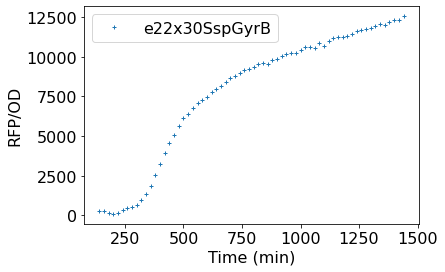

In [108]:
#IS.AutoRunInducibleSystem(Inputfile, NumDataSet, Inducer_unit, OptInhibition, SystemOpt)
IS.DataReader(Inputfile, NumDataSet, Inducer_unit)

Dose Response
132


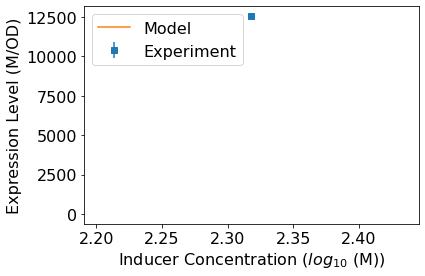

Param estimate for n: 2.2109385488013227
Param estimate for Kind : 194.1741246593915


In [109]:
IS.RunDoseResponsePrefitting()

In [110]:
IS.RunModels()

Time interval 20.0
ConstantInducer
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2

Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (Global): 10112585390.2714
Model:  ConstantInducer - SSE (

Model:  ConstantInducer - SSE (Local): 1325549857.7724304
Model:  ConstantInducer - SSE (Local): 1426469222.4654663
Model:  ConstantInducer - SSE (Local): 1295090924.0891883
Model:  ConstantInducer - SSE (Local): 1376739782.3617752
Model:  ConstantInducer - SSE (Local): 1303642633.0060222
Model:  ConstantInducer - SSE (Local): 1331447725.789911
Model:  ConstantInducer - SSE (Local): 1390986857.0127082
Model:  ConstantInducer - SSE (Local): 1290404477.8058665
Model:  ConstantInducer - SSE (Local): 1325630695.3637307
Model:  ConstantInducer - SSE (Local): 1290894332.1922307
Model:  ConstantInducer - SSE (Local): 1325387497.0736303
Model:  ConstantInducer - SSE (Local): 1285415555.7981024
Model:  ConstantInducer - SSE (Local): 1293663604.3589132
Model:  ConstantInducer - SSE (Local): 1318865545.6476789
Model:  ConstantInducer - SSE (Local): 1281446810.6503406
Model:  ConstantInducer - SSE (Local): 1303608122.190421
Model:  ConstantInducer - SSE (Local): 1280400657.1499631
Model:  Constant

<ipython-input-106-7d0f31fcd066>:27: RuntimeWarning: invalid value encountered in double_scalars
  dGFP_dt = (syn_GFP * ((ECF**n)/(ECF**n+K_ind**n))) - (deg_GFP * GFP)


 ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 872468406.5196435
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 861164389.4981426
Model:  ConstantInducer - SSE (Local): 713749140.6140028
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 829395690.3887383
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 825166378.5208683
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 821122451.4796273
Model:  ConstantInducer - SSE (Local): 639899615.2948024
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 802182639.7717822
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 783836760.5228425
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 779736398.3380985
Model:  ConstantInducer - SSE (Local): nan
Model: 

Model:  ConstantInducer - SSE (Local): 97953063.1487507
Model:  ConstantInducer - SSE (Local): 96619139.92289144
Model:  ConstantInducer - SSE (Local): 98006161.30694088
Model:  ConstantInducer - SSE (Local): 96450247.82092951
Model:  ConstantInducer - SSE (Local): 97143849.39163858
Model:  ConstantInducer - SSE (Local): 96481788.98256138
Model:  ConstantInducer - SSE (Local): 97228627.76367177
Model:  ConstantInducer - SSE (Local): 96434199.78681086
Model:  ConstantInducer - SSE (Local): 97048844.11205451
Model:  ConstantInducer - SSE (Local): 96421984.32889454
Model:  ConstantInducer - SSE (Local): 96980095.02500685
Model:  ConstantInducer - SSE (Local): 96410856.08602914
Model:  ConstantInducer - SSE (Local): 96991945.01177831
Model:  ConstantInducer - SSE (Local): 96379024.78267401
Model:  ConstantInducer - SSE (Local): 96988093.81288491
Model:  ConstantInducer - SSE (Local): 96362098.51957895
Model:  ConstantInducer - SSE (Local): 96874326.91692151
Model:  ConstantInducer - SSE (L

Model:  ConstantInducer - SSE (Local): 96293696.2081097
Model:  ConstantInducer - SSE (Local): 96294219.60576646
Model:  ConstantInducer - SSE (Local): 96293825.33187856
Model:  ConstantInducer - SSE (Local): 96293590.27110232
Model:  ConstantInducer - SSE (Local): 96292856.78145595
Model:  ConstantInducer - SSE (Local): 96293378.22893618
Model:  ConstantInducer - SSE (Local): 96293348.44196935
Model:  ConstantInducer - SSE (Local): 96293197.28815137
Model:  ConstantInducer - SSE (Local): 96293230.53099944
Model:  ConstantInducer - SSE (Local): 96292877.83831061
Model:  ConstantInducer - SSE (Local): 96292336.66668129
Model:  ConstantInducer - SSE (Local): 96291213.58991769
Model:  ConstantInducer - SSE (Local): 96291719.47199917
Model:  ConstantInducer - SSE (Local): 96292115.19976293
Model:  ConstantInducer - SSE (Local): 96291645.43375547
Model:  ConstantInducer - SSE (Local): 96291274.7721887
Model:  ConstantInducer - SSE (Local): 96291239.13628833
Model:  ConstantInducer - SSE (Lo

Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 95678036.5504644
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 95670501.06738885
Model:  ConstantInducer - SSE (Local): 93664126.46593262
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 95622919.44533138
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 95607047.10391423
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 95584589.04508545
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 95572969.17718025
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 95534379.62114684
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 95518491.1779404
Model:  ConstantInducer - SSE (Local): 93972628.5600744
Model:  ConstantInducer - SSE (Local): nan
Mod

Model:  ConstantInducer - SSE (Local): 93711646.29244778
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93708258.68795459
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93704498.11199562
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93700180.84268485
Model:  ConstantInducer - SSE (Local): 93634205.30432242
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93690230.0174342
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93687539.78021058
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93684711.26108499
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93681674.73383844
Model:  ConstantInducer - SSE (Local): 93630863.42499249
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93671955.45151727
Model:  ConstantInducer - SSE 

Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93629364.83416015
Model:  ConstantInducer - SSE (Local): 93629041.88500798
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93629302.45147699
Model:  ConstantInducer - SSE (Local): 93629025.15936556
Model:  ConstantInducer - SSE (Local): 93628847.49431175
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93629264.72699828
Model:  ConstantInducer - SSE (Local): 93628898.80262029
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93629228.32995169
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93629193.41027445
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93629170.98296398
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93629149.91905935
Model:  ConstantInducer - SSE (Local): 93628940.62497668
Model:  Constan

Model:  ConstantInducer - SSE (Local): 93547256.03576073
Model:  ConstantInducer - SSE (Local): 93546972.54335485
Model:  ConstantInducer - SSE (Local): 93546672.43461896
Model:  ConstantInducer - SSE (Local): 93546857.08335802
Model:  ConstantInducer - SSE (Local): 93546439.5542571
Model:  ConstantInducer - SSE (Local): 93546030.0314525
Model:  ConstantInducer - SSE (Local): 93546636.61660019
Model:  ConstantInducer - SSE (Local): 93546188.56147172
Model:  ConstantInducer - SSE (Local): 93546620.8764895
Model:  ConstantInducer - SSE (Local): 93546066.73833877
Model:  ConstantInducer - SSE (Local): 93546063.54307283
Model:  ConstantInducer - SSE (Local): 93545879.93877178
Model:  ConstantInducer - SSE (Local): 93545617.58440565
Model:  ConstantInducer - SSE (Local): 93545465.49437357
Model:  ConstantInducer - SSE (Local): 93544792.37320417
Model:  ConstantInducer - SSE (Local): 93545630.85963419
Model:  ConstantInducer - SSE (Local): 93545062.84225509
Model:  ConstantInducer - SSE (Loc

Model:  ConstantInducer - SSE (Local): 93528209.252859
Model:  ConstantInducer - SSE (Local): 93528235.0337834
Model:  ConstantInducer - SSE (Local): 93528196.1412795
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93528174.06565812
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93528164.58758794
Model:  ConstantInducer - SSE (Local): 93528355.11406724
Model:  ConstantInducer - SSE (Local): 93528121.5018377
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93528155.96377102
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93528146.4907838
Model:  ConstantInducer - SSE (Local): 93528200.50210436
Model:  ConstantInducer - SSE (Local): 93528115.0953294
Model:  ConstantInducer - SSE (Local): 93527988.73188289
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93528113.75783102
Model:  ConstantInducer - SSE (Local): nan
Model:  

Model:  ConstantInducer - SSE (Local): 93527253.58191274
Model:  ConstantInducer - SSE (Local): 93527234.25913255
Model:  ConstantInducer - SSE (Local): 93527206.39943585
Model:  ConstantInducer - SSE (Local): 93527053.80235995
Model:  ConstantInducer - SSE (Local): 93527100.62283786
Model:  ConstantInducer - SSE (Local): 93527061.94855872
Model:  ConstantInducer - SSE (Local): 93527015.71605577
Model:  ConstantInducer - SSE (Local): 93526796.34181781
Model:  ConstantInducer - SSE (Local): 93526924.32734697
Model:  ConstantInducer - SSE (Local): 93526855.99942732
Model:  ConstantInducer - SSE (Local): 93526819.09473549
Model:  ConstantInducer - SSE (Local): 93526745.7855038
Model:  ConstantInducer - SSE (Local): 93526467.97586825
Model:  ConstantInducer - SSE (Local): 93526643.92922914
Model:  ConstantInducer - SSE (Local): 93526545.58889793
Model:  ConstantInducer - SSE (Local): 93526428.45043294
Model:  ConstantInducer - SSE (Local): 93526040.25812012
Model:  ConstantInducer - SSE (L

Model:  ConstantInducer - SSE (Local): 93506591.07185131
Model:  ConstantInducer - SSE (Local): 93506565.01756436
Model:  ConstantInducer - SSE (Local): 93506549.49445082
Model:  ConstantInducer - SSE (Local): 93506567.65061827
Model:  ConstantInducer - SSE (Local): 93506556.2723961
Model:  ConstantInducer - SSE (Local): 93506575.44281371
Model:  ConstantInducer - SSE (Local): 93506542.18919
Model:  ConstantInducer - SSE (Local): 93506528.69314972
Model:  ConstantInducer - SSE (Local): 93506516.97372277
Model:  ConstantInducer - SSE (Local): 93506479.91799974
Model:  ConstantInducer - SSE (Local): 93506530.52842113
Model:  ConstantInducer - SSE (Local): 93506532.69813648
Model:  ConstantInducer - SSE (Local): 93506505.19352266
Model:  ConstantInducer - SSE (Local): 93506515.23159757
Model:  ConstantInducer - SSE (Local): 93506482.06717305
Model:  ConstantInducer - SSE (Local): 93506476.85035191
Model:  ConstantInducer - SSE (Local): 93506464.53929935
Model:  ConstantInducer - SSE (Loca

Model:  ConstantInducer - SSE (Local): 93497536.83313923
Model:  ConstantInducer - SSE (Local): 93497494.83934043
Model:  ConstantInducer - SSE (Local): 93497535.01311468
Model:  ConstantInducer - SSE (Local): 93497493.49824335
Model:  ConstantInducer - SSE (Local): 93497455.7923583
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93497482.17004727
Model:  ConstantInducer - SSE (Local): 93497437.04450645
Model:  ConstantInducer - SSE (Local): 93497425.33567965
Model:  ConstantInducer - SSE (Local): nan
Model:  ConstantInducer - SSE (Local): 93497436.78138405
Model:  ConstantInducer - SSE (Local): 93497426.86161698
Model:  ConstantInducer - SSE (Local): 93497437.12428056
*****Param list [array([ 2.31356129e+00,  5.45108689e+02,  9.60237810e+01,  1.10111887e-02,
       -1.83814499e-05,  1.14446773e-03,  1.37819013e+02, -1.63910066e-03,
        2.07635143e+01,  1.26752902e-03])]
*****Var Name [['ECFn', 'ECFc', 'ECF', 'GFP']]
*****Param Name [['n', 'K_ind',

Models Tested: ['Model 1.0 - ConstantInducer']
Number of Data points: 66
NumParam: [10]
SSE Results: [93497437.12428056]
AIC Results: [954.8101295338067]
Lowest SSE Value and Index: 93497437.12428056 , 0
Lowest AIC Value and Index: 954.8101295338067 , 0
Based on the lowest AIC value, the recommended characterization model is:
> Model 1.0 - ConstantInducer
ODEs in string [96.02367084811175, -2.982612712750698e-05, 0.013798292333224826, -0.3205707632554544]


<ipython-input-106-7d0f31fcd066>:27: RuntimeWarning: invalid value encountered in double_scalars
  dGFP_dt = (syn_GFP * ((ECF**n)/(ECF**n+K_ind**n))) - (deg_GFP * GFP)


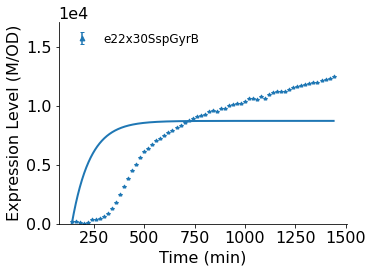

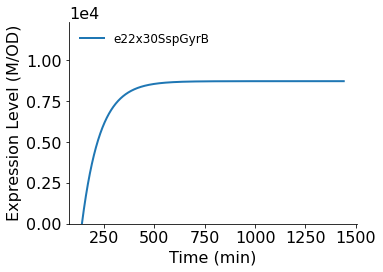

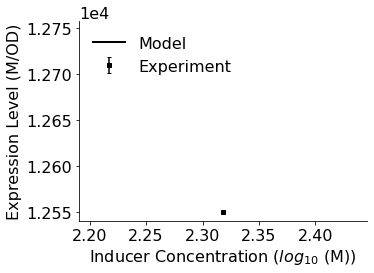

In [111]:
IS.RunModelSelection()

In [112]:
np.arange(0.25, 5, 0.25)

array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
       3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75])

In [ ]:
def hill_equation(x, K, n):
    return x**n / (K + x**n)

def hill_equation2(x, top, bottom, K, n):
    return bottom + (top - bottom) * x**n / (K**n + x**n)

def growth_rate(t, OD, mgr, mcc):
    return (mgr * (1 - (OD/mcc)))

def growth_rate2(t, OD, mgr, mcc, d, tlag):
    return (mgr * (1 - (OD/mcc)))/(1 + np.exp(-d * (t - tlag)))

def cell_density_solver(t, k1, k2):
    
    def cell_density_model(OD, t, mgr, mcc):
        dOD = growth_rate(t, OD[0], mgr, mcc) * OD[0]
        return dOD
    
    Ca0 = np.abs(odata[0])
    rates = (k1, k2)
    Casol = odeint(cell_density_model, Ca0, t, rates)
    return Casol[:,0]

def cell_density_solver2(t, k1, k2, k3, k4):
    
    def cell_density_model2(OD, t, mgr, mcc, d, tlag):
        dOD = growth_rate(t, OD[0], mgr, mcc, d, tlag) * OD[0]
        return dOD
    
    Ca0 = np.abs(odata[0])
    rates = (k1, k2, k3, k4)
    Casol = odeint(cell_density_model2, Ca0, t, rates)
    return Casol[:,0]

def intein_model(t, y, params, extra):
    
    # Dependent variables
    ECFn = y[0]
    ECFc = y[1]
    ECF = y[2]
    GFP = y[3]
    OD = y[4]
    # Parameters to infer
    syn_ECFn = params[0]
    deg_ECFn = params[1]
    syn_ECFc = params[2]
    deg_ECFc = params[3]
    syn_ECF = params[4]
    deg_ECF = params[5]
    syn_GFP = params[6]
    deg_GFP = params[7]
    #top = params[7]
    #bot = params[7]
    kind = params[8]
    n = params[9]
    # Parameters with fixed values
    mgr = extra[0]
    mcc = extra[1]
    # Differential equations
    dOD_dt = growth_rate(t, OD, mgr, mcc) * OD
    dECFn_dt = syn_ECFn - (deg_ECFn + growth_rate(t, OD, mgr, mcc)) * ECFn
    dECFc_dt = syn_ECFc - (deg_ECFc + growth_rate(t, OD, mgr, mcc)) * ECFc
    dECF_dt = syn_ECF * ECFn * ECFc - (deg_ECF * ECF)
    dGFP_dt = syn_GFP * hill_equation(ECF, kind, n) - (deg_GFP + growth_rate(t, OD, mgr, mcc)) * GFP

    return [dECFn_dt, dECFc_dt, dECF_dt, dGFP_dt, dOD_dt]

def objective_function(params, time_exp, f_exp, initial_conditions, extra, col):
    args = params 
    time_span = (np.min(time_exp), np.max(time_exp))
    
    y_model = ode_solver(initial_conditions, time_span, time_exp, args, extra)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y[col]
    
    residual = f_exp - simulated_ode_solution

    weight = 1.0
    return weight * np.sum(residual**2.0)

def ode_solver(y0, t_span, t_eval, params, extra):
    
    solution_ODE = solve_ivp(
        fun=intein_model, 
        t_span=t_span, 
        t_eval=t_eval,
        y0=y0,
        args=(params, extra),
        dense_output=True
    )
    return solution_ODE

input_col = 8

# Inference growth data
oddata = od[od.columns[input_col]]
t = np.arange(0, len(odata))
growth_params, _ = curve_fit(cell_density_solver, t, odata)

# Inference fluorescence data
data_to_fit = fluo[fluo.columns[input_col]]
t = np.arange(0, len(data_to_fit))

param_bounds = [(1e2, 5e2), (1e-2, 5e-2),
                (1e2, 5e2), (1e-2, 5e-2),
                (1e2, 5e2), (1e-2, 5e-2),
                (1e2, 5e2), (1e-2, 5e-2), (1e0, 1e2), (1e0, 2e0)]
#param_bounds = [(0, 1), (0, 1), (0, 1), (0, 1),
#               (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]
initial_params = np.abs([0.01, 0.01, 0.01, data_to_fit[0], 0.01])
extra = growth_params
print(extra)

output_col = 3
de_test = differential_evolution(
    objective_function, 
    bounds=param_bounds, 
    args=(t, data_to_fit, initial_params, extra, output_col),
    tol=1e-2,
    maxiter=100,
    disp=True
)
print(de_test.x)

fit = ode_solver(initial_params, [np.min(t), np.max(t)], t, de_test.x, extra)
plt.plot(t, data_to_fit, 'x', label='data')
plt.plot(fit.t, fit.y[3], '-', label='fit')
plt.legend(loc='best')
plt.show()

param_test = [8e2, 5e-2, #ECFc
              8e2, 5e-2, #ECFn
              8e2, 5e-1, #ECF
              15e2, 4e-2, #GFP
              1e1, 2e0]
fit = ode_solver(initial_params, [np.min(t), np.max(t)], t, param_test, extra)
plt.plot(t, data_to_fit, 'x', label='data')
plt.plot(fit.t, fit.y[0], '-', label='ECFn')
plt.plot(fit.t, fit.y[1], '-', label='ECFc')
#plt.plot(fit.t, fit.y[2], '-', label='ECF')
plt.plot(fit.t, fit.y[3], '-', label='GFP')
#plt.plot(fit.t, fit.y[4], '-', label='OD')
plt.legend(loc='best')
plt.show()